In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# ÂÆö‰πâÂõ†Â≠êÔºÅ

In [19]:
def factor(df, window_size = 960, threshold_value = 0.2, beta = 1.7):
    """
    ÊîπËøõÁöÑ ËÅ™ÊòéÈí±Âõ†Â≠ê (S = |R|/V^Œ≤)
    ËÆ°ÁÆóÊ≠•È™§:
    1. ËÆ°ÁÆóÊØèÊ†πKÁ∫øÁöÑÂπ≥Âùá‰ª∑ÂíåÊ∂®Ë∑åÂπÖÁªùÂØπÂÄº
    2. ÂõûÊ∫ØËøáÂéª10Â§©Ôºà960Ê†π15ÂàÜÈíüKÁ∫øÔºâÁöÑÊï∞ÊçÆ
    3. ËÆ°ÁÆóÊØèÊ†πKÁ∫øÁöÑSÂÄº = |Ê∂®Ë∑åÂπÖ| / sqrt(Êàê‰∫§Èáè)
    4. ÊåâSÂÄºÈôçÂ∫èÊéíÂ∫èÔºåÂèñÊàê‰∫§ÈáèÁ¥ØÁßØÂç†ÊØîÂâç20%ÁöÑKÁ∫ø
    5. ËÆ°ÁÆóËÅ™ÊòéÈí±VWAPÂíåÊï¥‰ΩìVWAP
    6. Âõ†Â≠êÂÄº = ËÅ™ÊòéÈí±VWAP / Êï¥‰ΩìVWAP
    """
    # È¢ÑËÆ°ÁÆóÊâÄÊúâÂøÖË¶ÅÂÄº
    avg_price = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    avg_price_vals = avg_price.values
    
    abs_ret = abs((df['close'] - df['open']) / df['open'])
    
    volume = df['volume'].values
        
    # ÂàùÂßãÂåñÂõ†Â≠êÂÄºÊï∞ÁªÑ
    factor_values = np.full(len(df), np.nan)
    
    # È¢ÑËÆ°ÁÆóSÂÄº (|R|/V^Œ≤)
    S_values = abs_ret.values / (volume ** beta)
    
    # ‰ΩøÁî®ÊªëÂä®Á™óÂè£ËÆ°ÁÆó
    for i in range(window_size, len(df)):
        # Ëé∑ÂèñÂΩìÂâçÁ™óÂè£ÂàáÁâáÁ¥¢Âºï
        start_idx = i - window_size
        end_idx = i - 1
        
        # ÊèêÂèñÂΩìÂâçÁ™óÂè£Êï∞ÊçÆ
        window_avg_price = avg_price_vals[start_idx:end_idx]
        window_volume = volume[start_idx:end_idx]
        window_S = S_values[start_idx:end_idx]
        
        # ÊåâSÂÄºÈôçÂ∫èÊéíÂ∫èÁöÑÁ¥¢Âºï
        sorted_idx = np.argsort(-window_S)
        sorted_volume = window_volume[sorted_idx]
        sorted_avg_price = window_avg_price[sorted_idx]
        
        # ËÆ°ÁÆóÁ¥ØÁßØÊàê‰∫§Èáè
        cum_volume = np.cumsum(sorted_volume)
        total_volume = cum_volume[-1]
        threshold = total_volume * threshold_value
        
        # ÊâæÂà∞ËÅ™ÊòéÈí±‰∫§ÊòìÁÇπ (Ââç20%Êàê‰∫§Èáè)
        smart_mask = cum_volume <= threshold
        if np.any(smart_mask):
            smart_vwap = np.sum(sorted_avg_price[smart_mask] * 
                               sorted_volume[smart_mask]) / np.sum(sorted_volume[smart_mask])
        else:
            smart_vwap = np.nan
        
        # ËÆ°ÁÆóÊï¥‰ΩìVWAP
        all_vwap = np.sum(window_avg_price * window_volume) / np.sum(window_volume)
        
        # ËÆ°ÁÆóÂõ†Â≠êÂÄº
        if not np.isnan(smart_vwap) and all_vwap != 0:
            factor_values[i] = smart_vwap / all_vwap
            
    return pd.Series(factor_values, index=df.index)

# ÊµãËØïÂõ†Â≠êË°®Áé∞


üìä ÂçïÂ∏ÅÁßç (single) ËØ¶ÁªÜËØÑ‰º∞ÁªìÊûú:
--------------------------------------------------
üîó Áõ∏ÂÖ≥ÊÄßÂàÜÊûê:
   IC (Pearson): -0.000999
   Rank_IC (Spearman): -0.003542
üìä ‰ø°ÊÅØÊØîÁéá:
   IR: 0.257716
   ÊúâÊïàÂàÜÁªÑÊï∞: 10
üìä Âõ†Â≠êÂàÜÂ∏É:
üìã Êï∞ÊçÆÊ¶ÇÂÜµ:
   Êï∞ÊçÆÈïøÂ∫¶: 127195
   Âõ†Â≠êÂàó: factor
   Êî∂ÁõäÁéáÂàó: future_return
   Êú™Êù•Êî∂ÁõäÂë®Êúü: 10
--------------------------------------------------

üñºÔ∏è  ÂçïÂ∏ÅÁßç (single) ÂõæÁâáÂ±ïÁ§∫:
----------------------------------------
üìä ÊòæÁ§∫ÂàÜÁªÑÂàÜÊûêÂõæ...


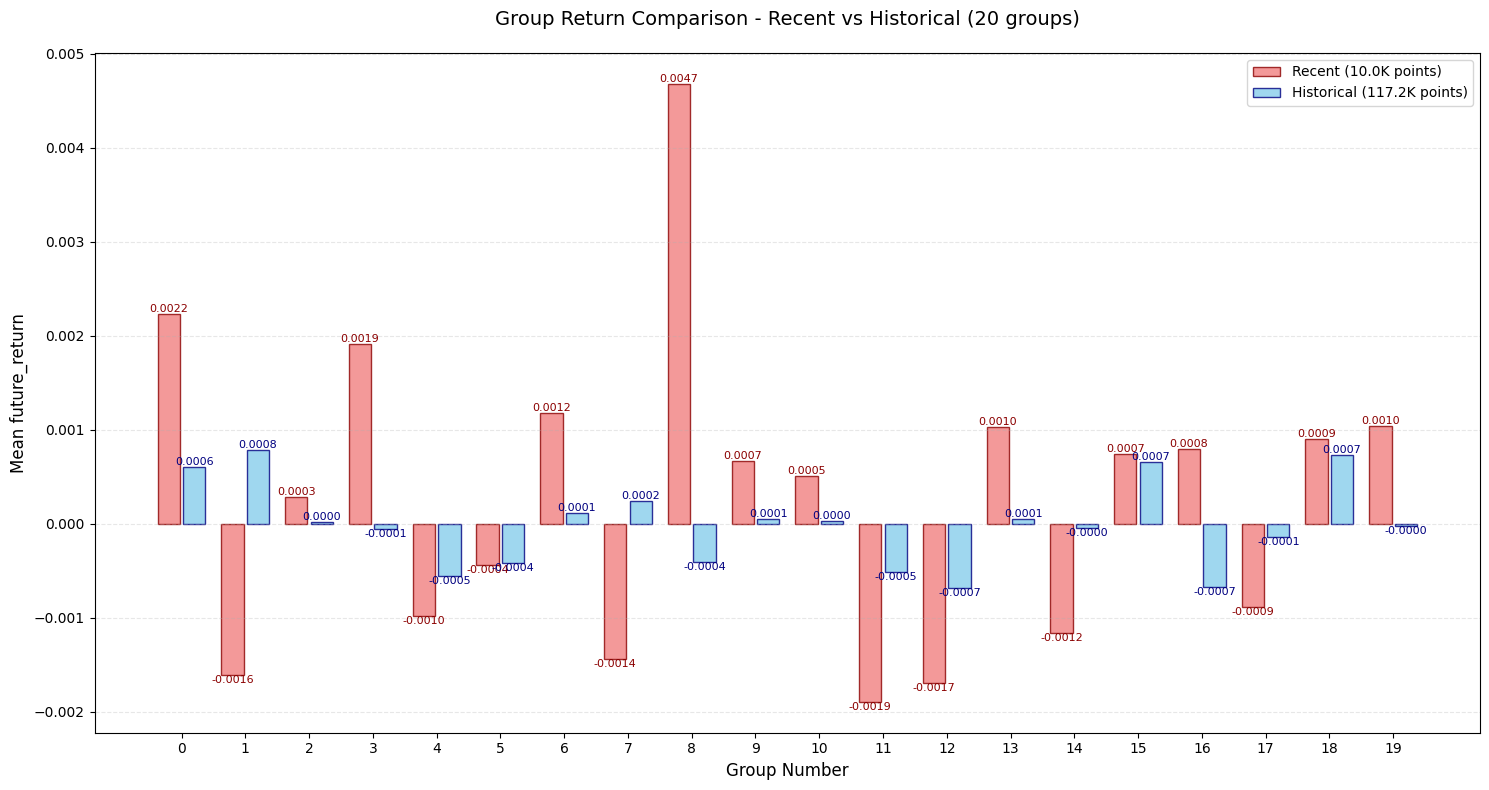

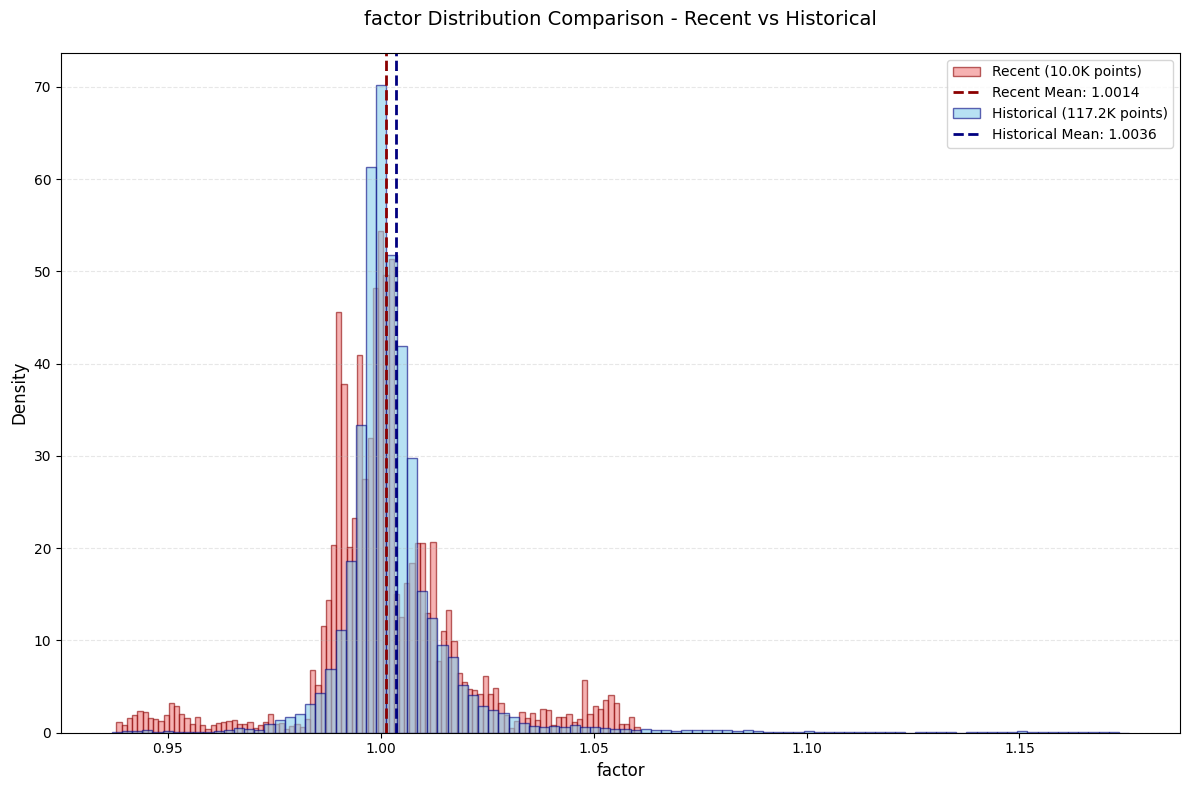

üìà ÊòæÁ§∫Âõ†Â≠êÂàÜÂ∏ÉÂõæ...
‚úÖ Â∑≤ÊòæÁ§∫ 2 ‰∏™ÂõæÁâá
----------------------------------------


In [20]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

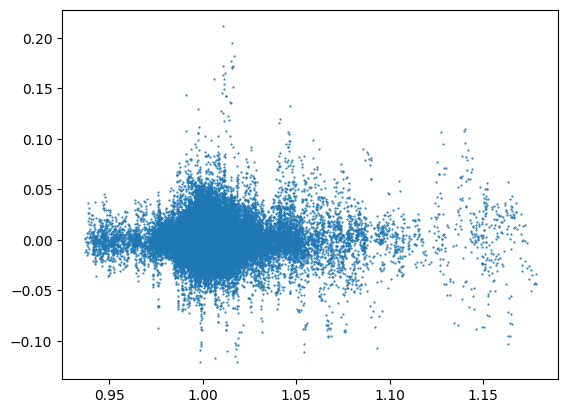

In [16]:
import matplotlib.pyplot as plt
plt.scatter(factor(df),df['close'].pct_change(-10), s=0.3)

In [17]:
result['information_ratio']['group_correlations']
# ËøôË°®Á§∫‰∏çÂêåÂàÜÁªÑ‰πãÈó¥ÁöÑÁõ∏ÂÖ≥ÊÄßÔºåÈÄöÂ∏∏Áî®‰∫éËØÑ‰º∞Âõ†Â≠êÂú®‰∏çÂêåÂ∏ÇÂú∫Áä∂ÊÄÅ‰∏ãÁöÑË°®Áé∞‰∏ÄËá¥ÊÄß„ÄÇ
# Â¶ÇÊûúÁõ∏ÂÖ≥ÊÄßËæÉÈ´òÔºåËØ¥ÊòéÂõ†Â≠êÂú®‰∏çÂêåÂ∏ÇÂú∫Áä∂ÊÄÅ‰∏ãË°®Áé∞‰∏ÄËá¥ÔºõÂ¶ÇÊûúÁõ∏ÂÖ≥ÊÄßËæÉ‰ΩéÔºåËØ¥ÊòéÂõ†Â≠êÂú®‰∏çÂêåÂ∏ÇÂú∫Áä∂ÊÄÅ‰∏ãË°®Áé∞Â∑ÆÂºÇËæÉÂ§ß„ÄÇ

[0.0015800754057782099,
 -0.033473092868445735,
 0.017181486275090457,
 -0.02378360315445531,
 0.019958907351615728,
 -0.024692461142798335,
 -0.007487569625661846,
 0.021496573214320233,
 0.03388128155044517,
 -0.001454084417073363]

In [18]:
print(result)

{'correlation_analysis': {'IC': -0.0009099401398770036, 'Rank_IC': -0.001884671217115632}, 'information_ratio': {'IR': 0.01485998750260155, 'group_correlations': [0.0015800754057782099, -0.033473092868445735, 0.017181486275090457, -0.02378360315445531, 0.019958907351615728, -0.024692461142798335, -0.007487569625661846, 0.021496573214320233, 0.03388128155044517, -0.001454084417073363], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0       0.9368   0.9883    0.9784       0.0003      0.0116   6408
1       0.9883   0.9924    0.9907       0.0008      0.0111   6408
2       0.9924   0.9948    0.9937       0.0001      0.0101   6408
3       0.9948   0.9962    0.9956      -0.0000      0.0098   6407
4       0.9962   0.9973    0.9968      -0.0005      0.0097   6408
5       0.9973   0.9981    0.9977      -0.0000      0.0100   6408
6       0.9981   0.9988    0.9985